In [2]:
import pandas as pd
from matplotlib import pyplot
import seaborn as sns; sns.set_theme()
import os
import glob

def get_files(fn):
    home = os.path.expanduser('~')
    path = f'{home}/Downloads/project_mining_2022/dataset/'
    files = glob.glob(path + fn + '/*.csv')
    return files


def to_date(char):
    return char[:4] + '-' + char[4:6] + '-' + char[6:8]

# for each file create a pandas df
# concatenate them all together
# change index to datetime
def parse_file(files, filenames):
    list_of_pandas = []
    for i, f in enumerate(files):
        # if file empty
        if os.stat(f).st_size != 0:
            # create df
            temp = pd.read_csv(f, header=0, nrows=288, skip_blank_lines=False)
            # create date column
            temp['Date'] = [to_date(filenames[i]) for _ in range(288)]
            # append df 
            list_of_pandas += [temp]
    # cast all together
    df = pd.concat(list_of_pandas, ignore_index=True)
    df.index = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y-%m-%d %H:%M:%S')
    df.drop(columns=['Date', 'Time'], inplace=True)
    return df

In [3]:
# list files
demand_files = get_files('demand')
source_files = get_files('sources')

# list filenames to use on timestamps
filenames = [file[-12: -4] for file in demand_files]

# get data from files
demands = parse_file(demand_files, filenames)
sources = parse_file(source_files, filenames)

# move values and drop temp cols
sources['Natural gas'].fillna(sources['Natural Gas'], inplace=True)
sources['Large hydro'].fillna(sources['Large Hydro'], inplace=True)
sources.drop(columns=['Natural Gas', 'Large Hydro'], inplace=True)

In [4]:
demands.shape

(315648, 3)

In [5]:
# null values in demands are probably due to power cut
# so, linear interpolation will be good estimate
demands.interpolate(method='linear', axis=0, inplace=True)

In [6]:
demands.isna().sum()
demands.loc[demands['Current demand'] <= 0]

,Day ahead forecast,Hour ahead forecast,Current demand
2019-10-02 14:45:00,24209.0,24727.0,-2651.0
2019-10-02 14:50:00,24209.0,24993.0,-2646.0


In [7]:
sources.isna().sum()

Solar           54
Wind            54
Geothermal     342
Biomass         54
Biogas          54
Small hydro     54
Coal            54
Nuclear         54
Natural gas    342
Large hydro     54
Batteries       54
Imports        342
Other           54
dtype: int64

In [8]:
sources.interpolate(method='linear', axis=0, inplace=True)

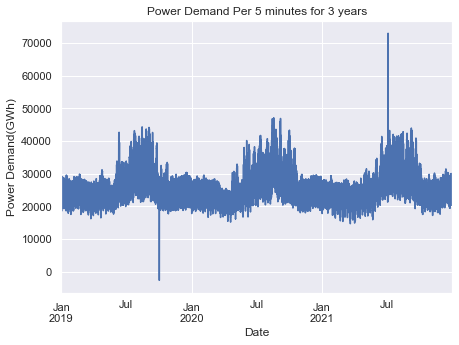

In [9]:
pyplot.rcParams['figure.figsize'] = [7, 5]
demands['Current demand'].plot(xlabel='Date', ylabel='Power Demand(GWh)', title = 'Power Demand Per 5 minutes for 3 years')
pyplot.show()

In [10]:
# Rolling mean and std for demand with a window of a day
demands_rolmean = demands['Current demand'].rolling(window=289).mean()
demands_rolstd = demands['Current demand'].rolling(window=289).std()

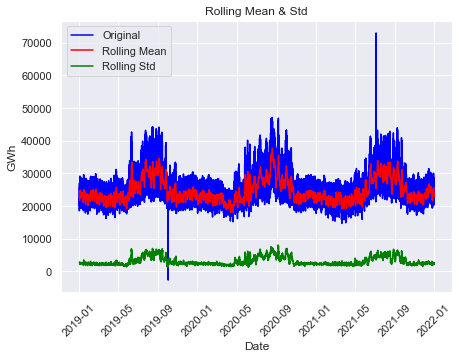

In [11]:
pyplot.title('Rolling Mean & Std')
pyplot.xlabel('Date')
pyplot.ylabel('GWh')
pyplot.plot(demands['Current demand'], color='blue', label='Original')
pyplot.plot(demands_rolmean, color='red', label='Rolling Mean')
pyplot.plot(demands_rolstd, color='green', label='Rolling Std')
pyplot.legend(loc='best')
pyplot.xticks(rotation=45)
pyplot.show()

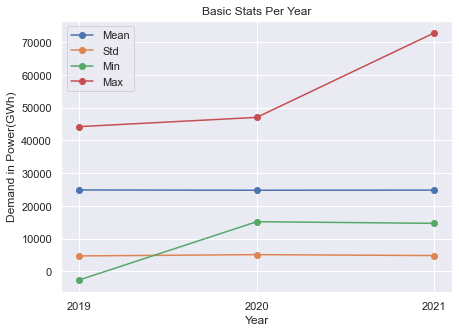

In [12]:
# calc mean, std, min, max per year
means = demands.groupby(by=demands.index.year).mean()['Current demand']
stds = demands.groupby(by=demands.index.year).std()['Current demand']
mins = demands.groupby(by=demands.index.year).min()['Current demand']
maxs = demands.groupby(by=demands.index.year).max()['Current demand']

basic_stats_year = pd.concat([means, stds, mins, maxs], axis=1, keys=['Mean', 'Std', 'Min', 'Max'])
basic_stats_year.plot(xlabel='Year', ylabel='Demand in Power(GWh)', title='Basic Stats Per Year', marker='o')
pyplot.xticks(demands.index.year.unique().values)
pyplot.show()

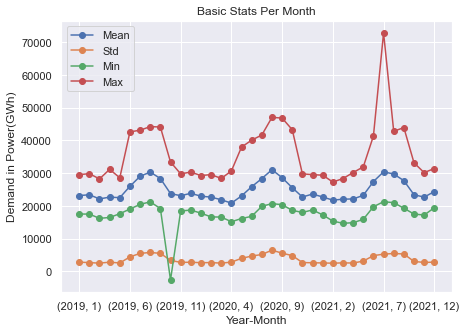

In [13]:
# calc mean, std, min, max per month
means = demands.groupby(by=[demands.index.year, demands.index.month]).mean()['Current demand']
stds = demands.groupby(by=[demands.index.year, demands.index.month]).std()['Current demand']
mins = demands.groupby(by=[demands.index.year, demands.index.month]).min()['Current demand']
maxs = demands.groupby(by=[demands.index.year, demands.index.month]).max()['Current demand']

basic_stats_year_month = pd.concat([means, stds, mins, maxs], axis=1, keys=['Mean', 'Std', 'Min', 'Max'])
basic_stats_year_month.plot(xlabel='Year-Month', ylabel='Demand in Power(GWh)', title='Basic Stats Per Month', marker='o')
pyplot.show()

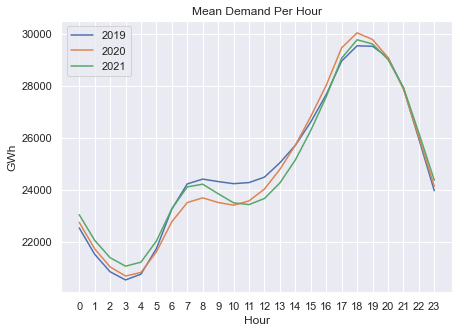

In [14]:
average_hour_per_year = demands.groupby(by=[demands.index.year, demands.index.hour]).mean()
pyplot.title('Mean Demand Per Hour')
pyplot.xlabel('Hour')
pyplot.ylabel('GWh')
pyplot.plot(average_hour_per_year[:24]['Current demand'].values, label='2019')
pyplot.plot(average_hour_per_year[24:48]['Current demand'].values, label='2020')
pyplot.plot(average_hour_per_year[48:]['Current demand'].values, label='2021')
pyplot.legend(loc='best')
pyplot.xticks(demands.index.hour.unique().values)
pyplot.show()

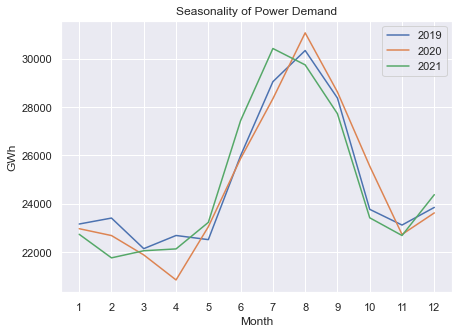

In [15]:
average_month_per_year = demands.groupby(by=[demands.index.year, demands.index.month]).mean()
pyplot.title('Seasonality of Power Demand')
pyplot.xlabel('Month')
pyplot.ylabel('GWh')
pyplot.plot(demands.index.month.unique().values, average_month_per_year[:12]['Current demand'].values, label='2019')
pyplot.plot(demands.index.month.unique().values, average_month_per_year[12:24]['Current demand'].values, label='2020')
pyplot.plot(demands.index.month.unique().values, average_month_per_year[24:]['Current demand'].values, label='2021')
pyplot.xticks(demands.index.month.unique().values)
pyplot.legend(loc='best')
pyplot.show()

In [134]:
### check for stationarity
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(demands['Current demand'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(demands['Current demand'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -30.645068252154445
p-value: 0.0
Critial Values:
   1%, -3.430370721762829
Critial Values:
   5%, -2.86154915876347
Critial Values:
   10%, -2.5667748748772925

KPSS Statistic: 2.341517
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


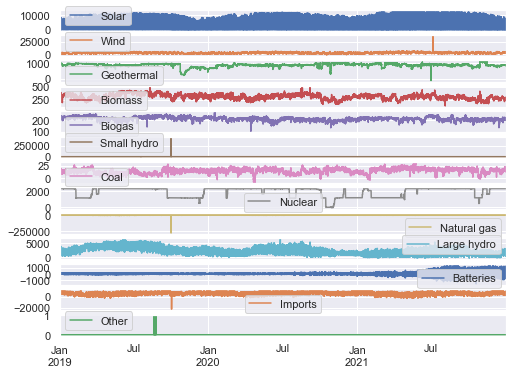

In [16]:
pyplot.rcParams['figure.figsize'] = [8, 6]
sources.plot(subplots=True)
pyplot.show()

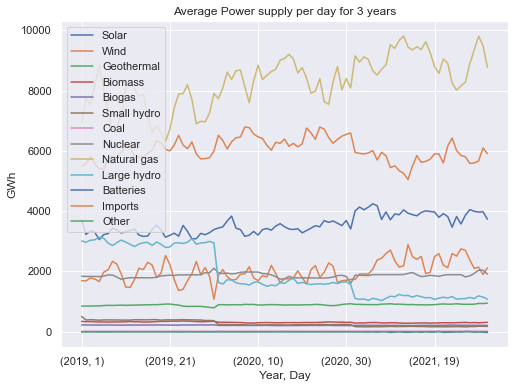

In [17]:
sources_day = sources.groupby(by=[sources.index.year, sources.index.day]).mean()
sources_day.plot(xlabel='Year, Day', ylabel='GWh', title='Average Power supply per day for 3 years')
pyplot.show()

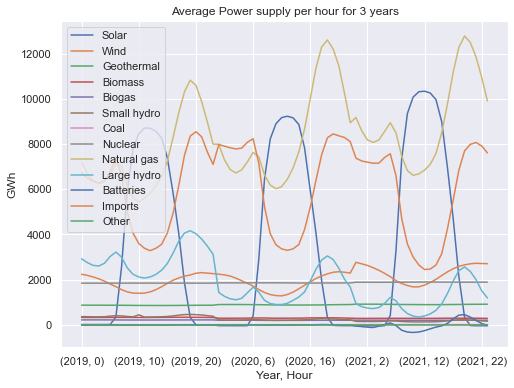

In [18]:
sources_hour = sources.groupby(by=[sources.index.year, sources.index.hour]).mean()
sources_hour.plot(xlabel='Year, Hour', ylabel='GWh', title='Average Power supply per hour for 3 years')
pyplot.show()